## Get the Data

In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install kaggle

In [7]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Micro-Organism"

In [6]:
!kaggle datasets download -d mdwaquarazam/microorganism-image-classification

 96% 97.0M/101M [00:01<00:00, 104MB/s] 
100% 101M/101M [00:01<00:00, 88.3MB/s]


In [8]:
import zipfile

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/Micro-Organism/microorganism-image-classification.zip")
zip_ref.extractall()
zip_ref.close()

In [3]:
# inspect the data
!ls /content/gdrive/MyDrive/Micro-Organism/Micro_Organism
micro_organism_directory = "/content/gdrive/MyDrive/Micro-Organism/Micro_Organism"

Amoeba	 Hydra	     Rod_bacteria	 Spiral_bacteria
Euglena  Paramecium  Spherical_bacteria  Yeast


In [4]:
# get class names
import pathlib
import numpy as np

data_dir = pathlib.Path(micro_organism_directory)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['Amoeba' 'Euglena' 'Hydra' 'Paramecium' 'Rod_bacteria'
 'Spherical_bacteria' 'Spiral_bacteria' 'Yeast']


In [5]:
# visualize images

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # setup the target directory
  target_folder = target_dir + "/" + target_class

  # get a random image path
  random_image = random.sample(os.listdir(target_folder), 1) # get 1
  print(random_image)

  # read the image and plot it
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")
  return img

['Image_56.jpg']
Image shape: (570, 725, 3)


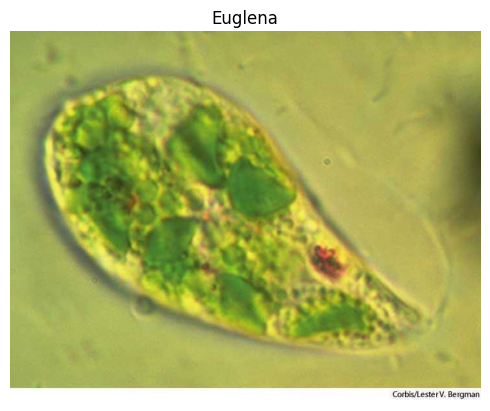

In [8]:
# visualize
import random
img = view_random_image(target_dir = micro_organism_directory,
                        target_class = random.choice(class_names))

## Preprocess the data

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255.,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split = 0.2) # set validation split

# load data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(micro_organism_directory,
                                               target_size = (224, 224),
                                               batch_size = 32,
                                               class_mode = "categorical",
                                               subset = "training") # set as training data

test_data = train_datagen.flow_from_directory(micro_organism_directory,
                                               target_size = (224, 224),
                                               batch_size = 32,
                                               class_mode = "categorical",
                                               subset='validation') # set as validation data

Found 633 images belonging to 8 classes.
Found 156 images belonging to 8 classes.


## Create a model

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# create a model
model_1 = Sequential([
    Conv2D(10, 3, input_shape = (224, 224, 3), activation = "relu"),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation = "relu"),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Flatten(),
    Dense(8, activation = "softmax")
])

# compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# fit the model
history_1 = model_1.fit(train_data,
            epochs = 5,
            steps_per_epoch = len(train_data),
            validation_data = test_data,
            validation_steps = len(test_data))

Epoch 1/5
20/20 [==============================] - 25s 1s/step - loss: 2.0344 - accuracy: 0.2417 - val_loss: 1.9902 - val_accuracy: 0.2564
Epoch 2/5
20/20 [==============================] - 21s 1s/step - loss: 1.9508 - accuracy: 0.2654 - val_loss: 1.9775 - val_accuracy: 0.2051
Epoch 3/5
20/20 [==============================] - 25s 1s/step - loss: 1.8777 - accuracy: 0.3065 - val_loss: 1.8745 - val_accuracy: 0.2372
Epoch 4/5
20/20 [==============================] - 22s 1s/step - loss: 1.7980 - accuracy: 0.3286 - val_loss: 1.8815 - val_accuracy: 0.3205
Epoch 5/5
20/20 [==============================] - 23s 1s/step - loss: 1.7327 - accuracy: 0.3555 - val_loss: 1.8280 - val_accuracy: 0.3077


## Evaluate the model

In [17]:
model_1.evaluate(test_data)

5/5 [==============================] - 4s 813ms/step - loss: 1.8118 - accuracy: 0.3205


[1.8118215799331665, 0.3205128312110901]

In [18]:
# plot validation
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # how many epochs

  # plot loss
  plt.plot(epochs, loss, label = "Training_loss")
  plt.plot(epochs, val_loss, label = "Val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # plot accuracy
  plt.figure() # create a new plot box
  plt.plot(epochs, accuracy, label = "Training_accuracy")
  plt.plot(epochs, val_accuracy, label = "Val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

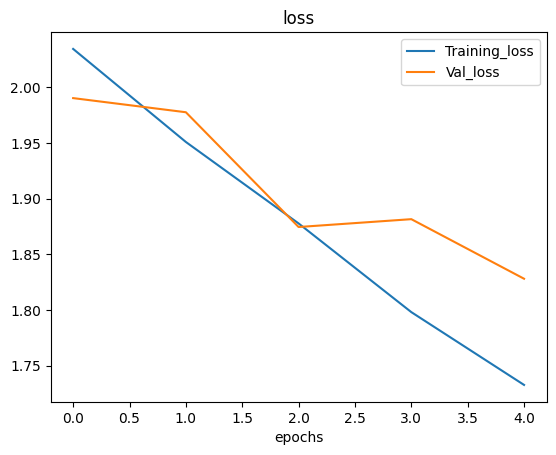

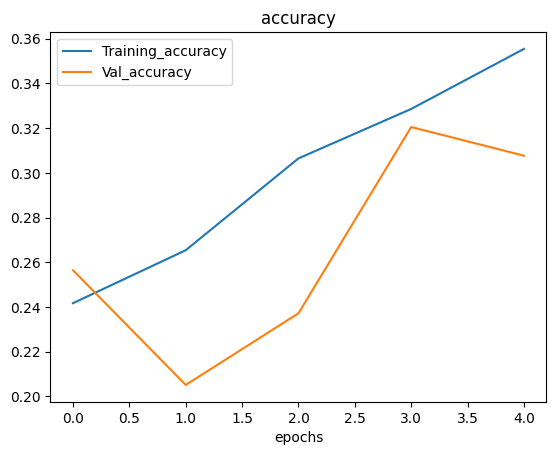

In [19]:
# check out the loss curves
plot_loss_curves(history_1)

## Make prediction with custom images

In [20]:
class_names

array(['Amoeba', 'Euglena', 'Hydra', 'Paramecium', 'Rod_bacteria',
       'Spherical_bacteria', 'Spiral_bacteria', 'Yeast'], dtype='<U18')

In [21]:
# function to import and resize image to be used in our model
def load_and_prep_image(filename, img_shape = 224):
  """
  Reads an image from filename, turn it into a tensor and reshape it
  """
  # read in the image
  img = tf.io.read_file(filename)
  # decode the read file into a tensor
  img = tf.image.decode_image(img)
  # resize the image
  img = tf.image.resize(img, size = [img_shape, img_shape])
  # rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [22]:
def pred_and_plot(model, filename, class_names = class_names):
  """
  import an image, make a prediction, and plot the image with the predicted class as the title
  """
  # import the target image and preprocess it
  img = load_and_prep_image(filename)

  # make a prediction
  pred = model.predict(tf.expand_dims(img, axis = 0))
  print(pred)

  # get the predicted class
  # 1. if multi class
  if(len(pred[0]) > 1):
    pred_class = class_names[tf.argmax(pred[0])]
  # 2. if binary class
  else:
    pred_class = class_names[int(tf.round(pred))]

  # plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

1/1 [==============================] - 0s 137ms/step
[[0.09266347 0.07730825 0.17726837 0.06631517 0.19216037 0.21383004
  0.1028825  0.07757184]]


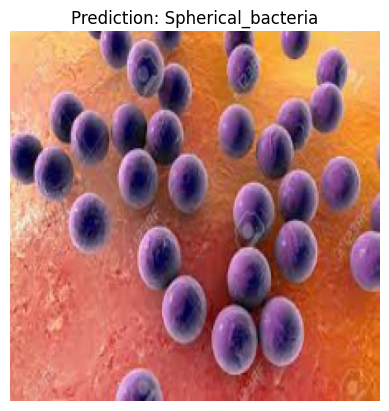

In [36]:
# make a prediction using model_10
pred_and_plot(model = model_1,
              filename = "Spherical_bacteria_ex.jpg",
              class_names = class_names)

## Confusion Matrix

In [27]:
# predictions probabilities
y_probs = model_1.predict(test_data)

5/5 [==============================] - 7s 1s/step


In [28]:
# view the first 5 prediction
y_probs[:5]

array([[0.10621645, 0.2430481 , 0.01579926, 0.197239  , 0.16146106,
        0.15848945, 0.08277226, 0.03497445],
       [0.02449467, 0.8099812 , 0.00342188, 0.13627021, 0.00483219,
        0.01426248, 0.00420026, 0.00253706],
       [0.23862498, 0.20916907, 0.00756565, 0.18327114, 0.1707613 ,
        0.10352043, 0.07161675, 0.01547067],
       [0.09252211, 0.08812716, 0.08149751, 0.19513927, 0.16439106,
        0.14402778, 0.07934111, 0.15495402],
       [0.03032472, 0.01208601, 0.00383273, 0.00634753, 0.37645042,
        0.06814004, 0.19554156, 0.307277  ]], dtype=float32)

In [29]:
class_names

array(['Amoeba', 'Euglena', 'Hydra', 'Paramecium', 'Rod_bacteria',
       'Spherical_bacteria', 'Spiral_bacteria', 'Yeast'], dtype='<U18')

In [30]:
list(class_names)

['Amoeba',
 'Euglena',
 'Hydra',
 'Paramecium',
 'Rod_bacteria',
 'Spherical_bacteria',
 'Spiral_bacteria',
 'Yeast']

In [31]:
# convert all the predictions probabilities into integers
y_preds = y_probs.argmax(axis = 1)
y_preds[:5]

array([1, 1, 0, 3, 4])

In [32]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true = test_data.labels,
                 y_pred = y_preds)

array([[ 1,  6,  1,  5,  1,  0,  0,  0],
       [ 1,  8,  5, 16,  2,  0,  0,  1],
       [ 0,  0,  3,  6,  3,  2,  0,  1],
       [ 1,  4,  2, 15,  4,  2,  0,  2],
       [ 0,  5,  2,  8,  2,  0,  0,  0],
       [ 1,  2,  1, 12,  1,  0,  0,  0],
       [ 0,  5,  2,  6,  1,  1,  0,  0],
       [ 0,  5,  0,  8,  2,  0,  0,  0]])

In [33]:
# create cofusion matrix
import itertools
from sklearn.metrics import confusion_matrix

figsize = (10, 10)

def make_confusion_matrix(y_true, y_pred, classes = None, figsize = (10, 10), text_size = 15):
  # create the confusion matrix
  cm = confusion_matrix(y_true,  y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis = 1)[:, np.newaxis] # normalize confusion matrix
  n_classes = cm.shape[0]

  # prettify it
  fig, ax = plt.subplots(figsize = figsize)
  # create a matrix plot
  cax = ax.matshow(cm, cmap = plt.cm.Blues)
  fig.colorbar(cax)

  # create classes
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # label the axes
  ax.set(title = "Confusion Matrix",
        xlabel = "Predicted Label",
        ylabel = "True Label",
        xticks = np.arange(n_classes),
        yticks = np.arange(n_classes),
        xticklabels = labels,
        yticklabels = labels)

  # set x-axis labels to bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # adjust the label size
  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)

  # set threshold for different colors
  threshold = (cm.max() + cm.min()) / 2

  # plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
            horizontalalignment = "center",
            color = "white" if cm[i, j] > threshold else "black",
            size = text_size)

In [34]:
len(test_data.labels), len(y_preds)

(156, 156)

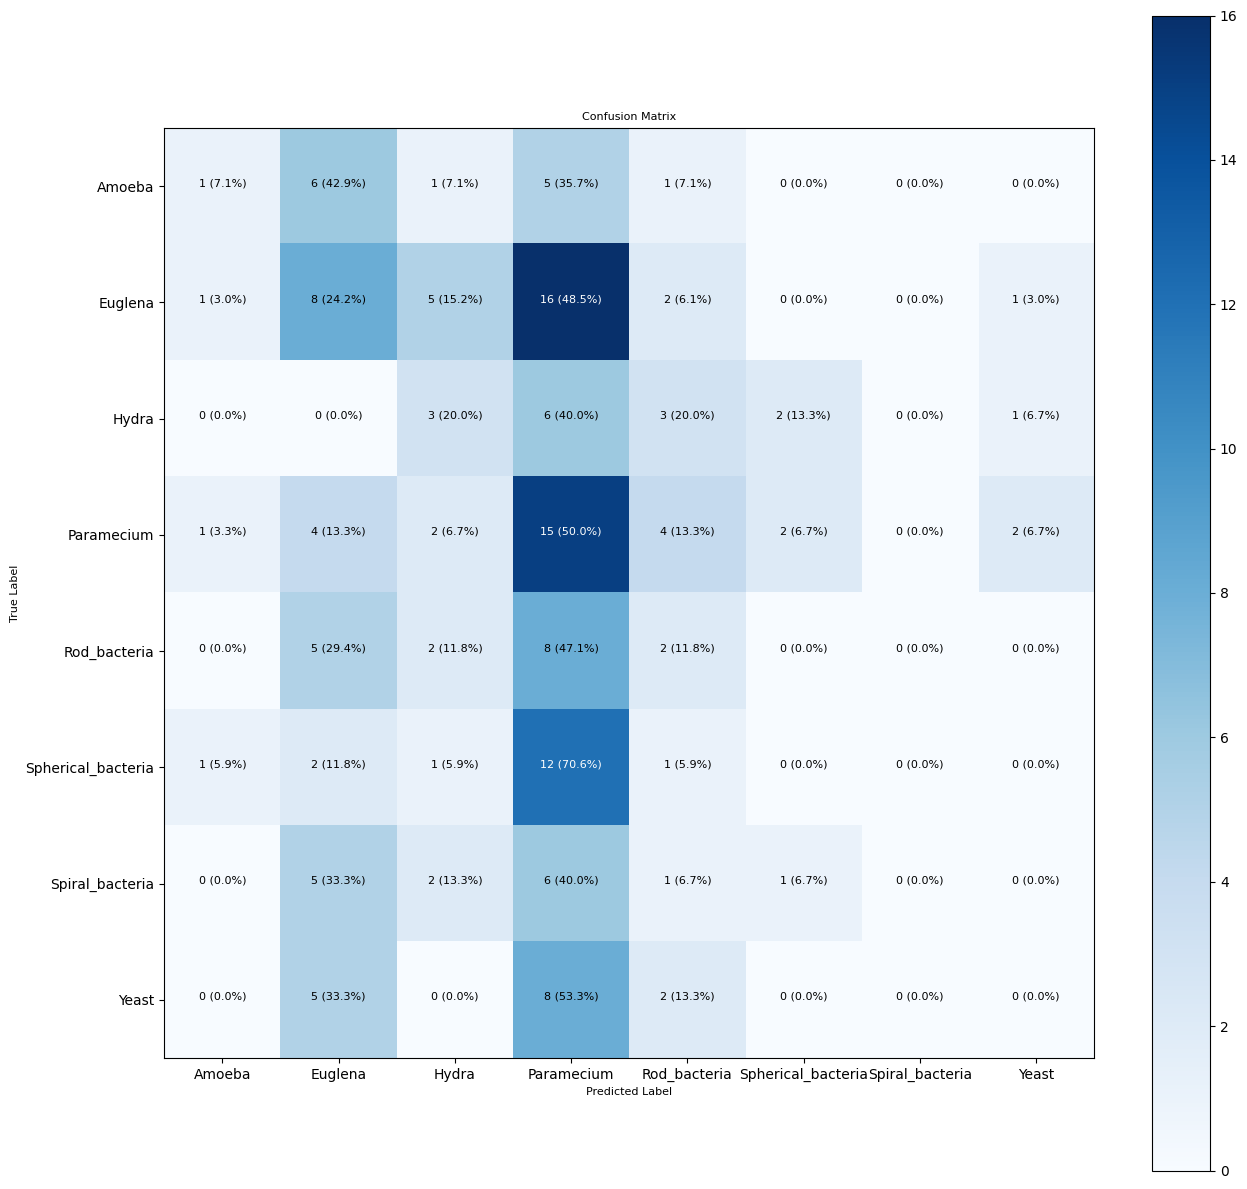

In [35]:
make_confusion_matrix(y_true = test_data.labels, y_pred = y_preds, classes = list(class_names), figsize = (15, 15), text_size = 8)